# BCR clustering

![dandelion_logo](img/dandelion_logo_illustration.png)

On the topic of finding clones/clonotypes, there are many ways used for clustering BCRs, almost all involving some measure based on sequence similarity. There are also a lot of very well established guidelines and criterias maintained by the BCR community. For example, *immcantation* uses a number of model-based [methods](https://changeo.readthedocs.io/en/stable/methods/clustering.html) to group clones based on the distribution of length-normalised junctional hamming distance while others use the whole BCR V(D)J sequence to define clones as shown in this recent [paper](https://www.nature.com/articles/s41586-019-1595-3.pdf).

***Import modules***

In [1]:
import os
import pandas as pd
import dandelion as ddl
ddl.logging.print_header()

dandelion==0.1.2.dev3 pandas==1.2.3 numpy==1.20.1 matplotlib==3.3.4 networkx==2.5 scipy==1.6.1 skbio==0.5.6


In [2]:
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
# I'm importing scanpy here to make use of its logging module.
import scanpy as sc
sc.settings.verbosity = 3
import warnings
warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.6 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


***Read in the previously saved files***

I will work with the same example from the previous notebook since I have the filtered V(D)J data stored in a `Dandelion` class.

In [3]:
vdj = ddl.read_h5('dandelion_results.h5')
vdj

Dandelion class object with n_obs = 1004 and n_contigs = 2013
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start'

## Finding clones

The following is *dandelion*'s implementation of a rather conventional method to define clones, `tl.find_clones`. 

Clone definition is based on the following criterias:

    (1) Identical IGH V-J gene usage.

    (2) Identical CDR3 junctional sequence length.

    (3) CDR3 Junctional sequences attains a minimum of % sequence similarity, based on hamming distance. The similarity cut-off is tunable (default is 85%).

    (4) Light chain usage. If cells within clones use different light chains, the clone will be splitted following the same conditions for heavy chains in (1-3) as above. 

The 'clone_id' name follows a `{A}_{B}_{C}_{D}` format and largely reflects the conditions above where:

    {A} indicates if the contigs use the same IGH V/J genes.
    
    {B} indicates if IGH junctional sequences are equal in length.
    
    {C} indicates if clones are splitted based on junctional hamming distance threshold
    
    {D} indicates light chain pairing. 

The last position will not be annotated if there's only one group of light chains usage detected in the clone.

### Running `tl.find_clones`
The function will take a file path, a pandas `DataFrame` (for example if you've used pandas to read in the filtered file already), or a `Dandelion` class object. The default mode for calculation of junctional hamming distance is to use the CDR3 junction amino acid sequences, specified via the `key` option (`None` defaults to `junction_aa`). You can switch it to using CDR3 junction nucleotide sequences (`key = 'junction'`, or even the full V(D)J amino acid sequence (`key = 'sequence_alignment_aa`), as long as the column name exists in the `.data` slot.

If you want to use the alleles for defining V-J gene usuage, specify:
```python
by_alleles = True
```

Clustering TCR is potentially possible with the same setup, although some parameters may need to be tweaked.

In [4]:
ddl.tl.find_clones(vdj)
vdj

Finding clonotypes


Finding clones based on VDJ chains : 100%|██████████| 188/188 [00:00<00:00, 2282.25it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 1004/1004 [00:00<00:00, 269733.62it/s]


 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:00)


Dandelion class object with n_obs = 1004 and n_contigs = 2013
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start'

This will return a new column with the column name `'clone_id'` as per convention. If a file path is provided as input, it will also save the file automatically into the base directory of the file name. Otherwise, a `Dandelion` object will be returned.

In [5]:
vdj.metadata

,clone_id,clone_id_by_size,sample_id,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_genotyped_VDJ,v_call_genotyped_VJ,j_call_VDJ,...,junction_aa_VJ,status,status_summary,productive,productive_summary,isotype,isotype_summary,vdj_status,vdj_status_summary,VDJ_chain_status_summary
sc5p_v2_hs_PBMC_1k_AACTCTTGTCATCGGC,54_7_1_334,125,sc5p_v2_hs_PBMC_1k,IGH,IGL,T,T,IGHV3-21,IGLV4-69,IGHJ4,...,CQTWGTGIYVF,IGH + IGL,IGH + IGL,T + T,T + T,IgM,IgM,Single + Single,Single,Single
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG,25_9_3_411,764,sc5p_v2_hs_PBMC_1k,IGH,IGL,T,T,IGHV3-15,IGLV3-1,IGHJ4,...,CQAWDSSNVVF,IGH + IGL,IGH + IGL,T + T,T + T,IgM,IgM,Single + Multi_VJ_j,Single,Single
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC,116_6_1_140,974,sc5p_v2_hs_PBMC_1k,IGH,IGK,T,T,IGHV3-30,IGKV3-20,IGHJ6,...,CQQYGSSPPFTF,IGH + IGK,IGH + IGK,T + T,T + T,IgM,IgM,Single + Single,Single,Single
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG,65_2_4_191,919,sc5p_v2_hs_PBMC_1k,IGH,IGK,T,T,IGHV1-18,IGKV4-1,IGHJ4,...,CQQYYSTPITF,IGH + IGK,IGH + IGK,T + T,T + T,IgM,IgM,Single + Single,Single,Single
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC,23_11_2_176,264,sc5p_v2_hs_PBMC_1k,IGH,IGK,T,T,IGHV3-23,IGKV1-8,IGHJ4,...,CQQYYSYPRTF,IGH + IGK,IGH + IGK,T + T,T + T,IgM,IgM,Single + Single,Single,Single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT,129_2_1_256,709,vdj_nextgem_hs_pbmc3,IGH,IGK,T,T,IGHV4-59,IGKV3-11,IGHJ6,...,CQQRSNWPLITF,IGH + IGK,IGH + IGK,T + T,T + T,IgM,IgM,Single + Single,Single,Single
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA,133_5_2_81,813,vdj_nextgem_hs_pbmc3,IGH,IGL,T,T,IGHV3-7,IGLV1-51,IGHJ6,...,CGTWDSSLSAVVF,IGH + IGL,IGH + IGL,T + T,T + T,IgM,IgM,Single + Multi_VJ_j,Single,Single
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT,110_2_2_55,3,vdj_nextgem_hs_pbmc3,IGH,IGL,T,T,IGHV2-26,IGLV9-49,IGHJ4,...,CGADHGSGSNFVSVF,IGH + IGL,IGH + IGL,T + T,T + T,IgM,IgM,Single + Single,Single,Single
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA,65_7_1_117,153,vdj_nextgem_hs_pbmc3,IGH,IGK,T,T,IGHV1-18,IGKV1-27,IGHJ4,...,CQKYNSALPTF,IGH + IGK,IGH + IGK,T + T,T + T,IgM,IgM,Single + Single,Single,Single


### Alternative : Running `tl.define_clones`

Alternatively, a wrapper to call *changeo's* `DefineClones.py` is also included. To run it, you need to choose the distance threshold for clonal assignment. To facilitate this, the function `pp.calculate_threshold` will run [shazam's distToNearest](https://shazam.readthedocs.io/en/stable/topics/distToNearest/) function and return a plot showing the length normalized hamming distance distribution and automated threshold value. 

Again, `pp.calculate_threshold` will take a file path, pandas `DataFrame` or `Dandelion` object as input. If a dandelion object is provided, the threshold value will be inserted into the `.threshold` slot. For more fine control, please use the `DefineClones.py` function [directly](https://immcantation.readthedocs.io/en/stable/tutorials/10x_tutorial.html).


Calculating threshold
      Threshold method 'density' did not return with any values. Switching to method = 'gmm'.


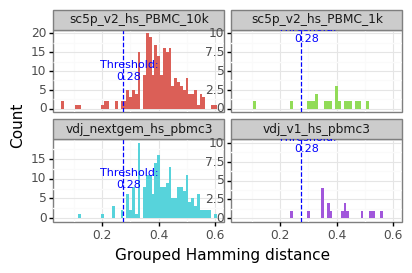

<ggplot: (354422757)>
 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:02:09)


In [6]:
ddl.pp.calculate_threshold(vdj)

In [7]:
# see the actual value in .threshold slot
vdj.threshold

0.27510012225781544

You can also manually select a value as the threshold if you wish.

Calculating threshold
      Threshold method 'density' did not return with any values. Switching to method = 'gmm'.


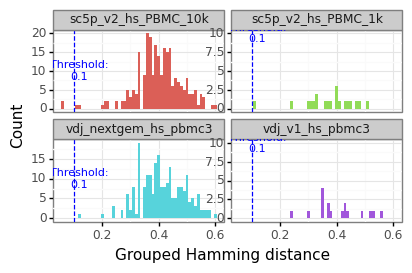

<ggplot: (365394405)>
 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:01:29)


In [8]:
ddl.pp.calculate_threshold(vdj, manual_threshold = 0.1)

In [9]:
# see the updated .threshold slot
vdj.threshold

0.1


We can run `tl.define_clones` to call *changeo's* `DefineClones.py`; see [here](https://changeo.readthedocs.io/en/stable/methods/clustering.html) for more info. Note, if a `pandas.DataFrame` or file path is provided as the input, the value in dist option (corresponds to threshold value) needs to be manually supplied. If a `Dandelion` object is provided, it will automatically retrieve it from the threshold slot. 

In [10]:
ddl.tl.define_clones(vdj, key_added = 'changeo_clone_id')
vdj

Finding clones
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:30)


Dandelion class object with n_obs = 1004 and n_contigs = 2013
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start'

Note that I specified the option `key_added` and this adds the output from `tl.define_clones` into a separate column. If left as default (`None`), it will write into `clone_id` column. The same option can be specified in `tl.find_clones` earlier.

## Generation of V(D)J network
*dandelion* generates a network to facilitate visualisation of results. This uses the full V(D)J contig sequences instead of just the junctional sequences to chart a tree-like network for each clone. The actual visualization will be achieved through `scanpy` later.

**tl.generate_network**

First we need to generate the network. `tl.generate_network` will take a V(D)J table that has clones defined, specifically under the `'clone_id'` column. The default mode is to use amino acid sequences for constructing Levenshtein distance matrices, but can be toggled using the `key` option.

If you have a pre-processed table parsed from immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html), or any other method as long as it's in a *AIRR* format, the table can be used as well.

You can specify the `clone_key` option for generating the network for the clone id definition of choice as long as it exists as a column in the `.data` slot.

In [11]:
ddl.tl.generate_network(vdj)

Generating network


Linking edges : 100%|██████████| 987/987 [00:01<00:00, 638.90it/s]


generating network layout
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
   'distance', heavy and light chain distance matrices
   'edges', network edges
   'layout', network layout
   'graph', network (0:00:28)


This step works reasonably fast here but will take quite a while when a lot of contigs are provided.

You can also downsample the number of cells. This will return a new object as a downsampled copy of the original with it's own distance matrix.

In [12]:
vdj_downsample = ddl.tl.generate_network(vdj, downsample = 500)
vdj_downsample

Generating network
Downsampling to 500 cells.


Linking edges : 100%|██████████| 491/491 [00:00<00:00, 2858.46it/s]


generating network layout
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
   'distance', heavy and light chain distance matrices
   'edges', network edges
   'layout', network layout
   'graph', network (0:00:10)


Dandelion class object with n_obs = 499 and n_contigs = 999
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start', 

**check the newly re-initialized Dandelion object**

In [13]:
vdj

Dandelion class object with n_obs = 1004 and n_contigs = 2013
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start'

The graph/networks can be accessed through the `.graph` slot as an `networkx` graph object if you want to extract the data for network statistics or make any changes to the network.

At this point, we can save the dandelion object; the file can be quite big because the distance matrix is not sparse. I reccomend some form of compression (I use `bzip2` below but that can impact on read/write times significantly). See [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_hdf.html) for options compression options.

In [14]:
vdj.write_h5('dandelion_results.h5', complib = 'bzip2')